In [13]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
import time as timer
import random

In [14]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [15]:
print(torch.cuda.is_available())  # Should return True if CUDA is properly installed
print(torch.__version__)          # Check PyTorch version
print(torch.version.cuda)         # Check which CUDA version PyTorch is using

True
2.2.2+cu121
12.1


In [16]:
def plot_channels(W, name):
    #number of output channels 
    n_out=W.shape[0]
    #number of input channels 
    n_in=W.shape[1]
    w_min=W.min().item()
    w_max=W.max().item()
    fig, axes = plt.subplots(n_out,n_in, figsize=(10,10))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    out_index=0
    in_index=0
    #plot outputs as rows inputs as columns 
    print(name)
    for ax in axes.flat:

        if in_index>n_in-1:
            out_index=out_index+1
            in_index=0

        ax.imshow(W[out_index,in_index,:,:], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index=in_index+1

    plt.show()

In [17]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [18]:
def plot_activations(A,number_rows= 1,name=""):
    A=A[0,:,:,:].detach().numpy()
    n_activations=A.shape[0]


    print(n_activations)
    A_min=A.min().item()
    A_max=A.max().item()

    if n_activations==1:

        # Plot the image.
        plt.imshow(A[0,:], vmin=A_min, vmax=A_max, cmap='seismic')

    else:
        fig, axes = plt.subplots(number_rows, n_activations//number_rows,figsize=(10,10))
        fig.subplots_adjust(hspace = 3)
        print(name)
        for i,ax in enumerate(axes.flat):
            if i< n_activations:
                # Set the label for the sub-plot.
                ax.set_xlabel( "activation:{0}".format(i+1))

                # Plot the image.
                ax.imshow(A[i,:], vmin=A_min, vmax=A_max, cmap='seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()

In [19]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows, figsize=(10,10))
    fig.subplots_adjust(hspace=3,wspace=1)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)
    plt.show()

In [20]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [21]:
def train_model(model, optimizer, criterion, train_loader, validation_loader, validation_dataset, use_cuda, n_epochs):
    
    # Assuming these are already defined elsewhere in your script:
    # model, criterion, optimizer, train_loader, validation_loader, n_epochs, validation_dataset
    
    # Check if CUDA is available and set the device accordingly
    
    if use_cuda:
        device = torch.device("cuda")
        print("Using GPU")
    else:
        device = torch.device("cpu")
        print("Using CPU")
        
    model.to(device=device)  # Send the model to the designated device
    
    # Initialization of metrics
    N_test = len(validation_dataset)  # Number of samples in the validation dataset
    accuracy_list = []
    loss_list = []
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)  # Move the data to the device
            optimizer.zero_grad()  # Clear the gradients
            z = model(x)  # Forward pass
            loss = criterion(z, y)  # Calculate the loss
            loss.backward()  # Backpropagate the errors
            optimizer.step()  # Update the weights
            loss_list.append(loss.item())  # Store the loss
    
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        correct = 0
        with torch.no_grad():  # Disable gradient computation
            for x_test, y_test in validation_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)  # Move the data to the device
                z = model(x_test)  # Forward pass
                _, yhat = torch.max(z.data, 1)  # Get the predictions
                correct += (yhat == y_test).sum().item()  # Count correct predictions
    
        # Calculate accuracy and store it
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
    
    # Output the collected accuracy and loss data
    return accuracy_list, loss_list


In [22]:
class CNN_batch(nn.Module):

    # Contructor
    def __init__(self, out_1=28, out_2=56, out_3=100, number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=5, stride=1, padding=2)
        self.conv3_bn = nn.BatchNorm2d(out_3)

        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_3*9, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

    def activations(self, x):
        #outputs activation 
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out0 = self.maxpool1(a1)

        z2 = self.cnn2(out0)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)

        z3 = self.cnn3(out1)
        a3 = torch.relu(z3)
        out2 = self.maxpool3(a3)
        
        out = out0.view(out0.size(0),-1)
        return z1, a1, z2, a2, z3, a3, out0, out1, out2, out

In [23]:
model_CNN_BATCH_CPU = CNN_batch()
model_CNN_BATCH_GPU = CNN_batch()
print(model_CNN_BATCH_CPU)

CNN_batch(
  (cnn1): Conv2d(1, 28, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(28, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(56, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_bn): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=900, out_features=10, bias=True)
  (bn_fc1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
out=conv_output_shape((28,28), kernel_size=5, stride=1, pad=2, dilation=1)
print('Image size after first convolution:',out)
out1=conv_output_shape(out, kernel_size=5, stride=1, pad=2, dilation=1)
print('Image size after second convolution:',out1)
out2=conv_output_shape(out1, kernel_size=5, stride=1, pad=2, dilation=1)
print('Image size after third convolution:',out2)

Image size after first convolution: (28, 28)
Image size after second convolution: (28, 28)
Image size after third convolution: (28, 28)


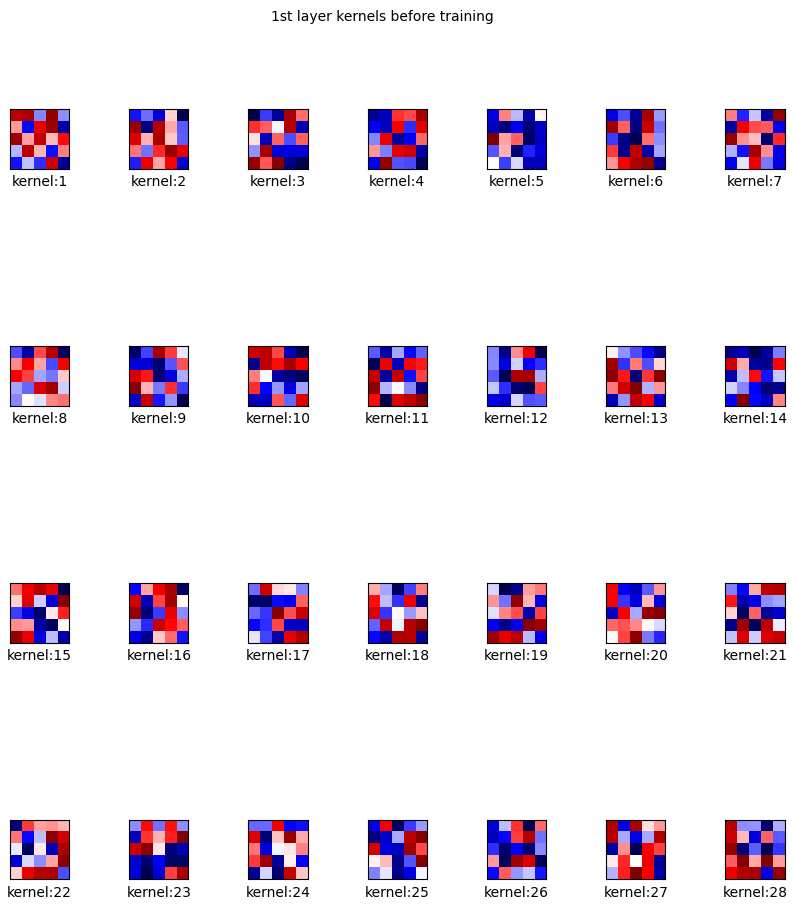

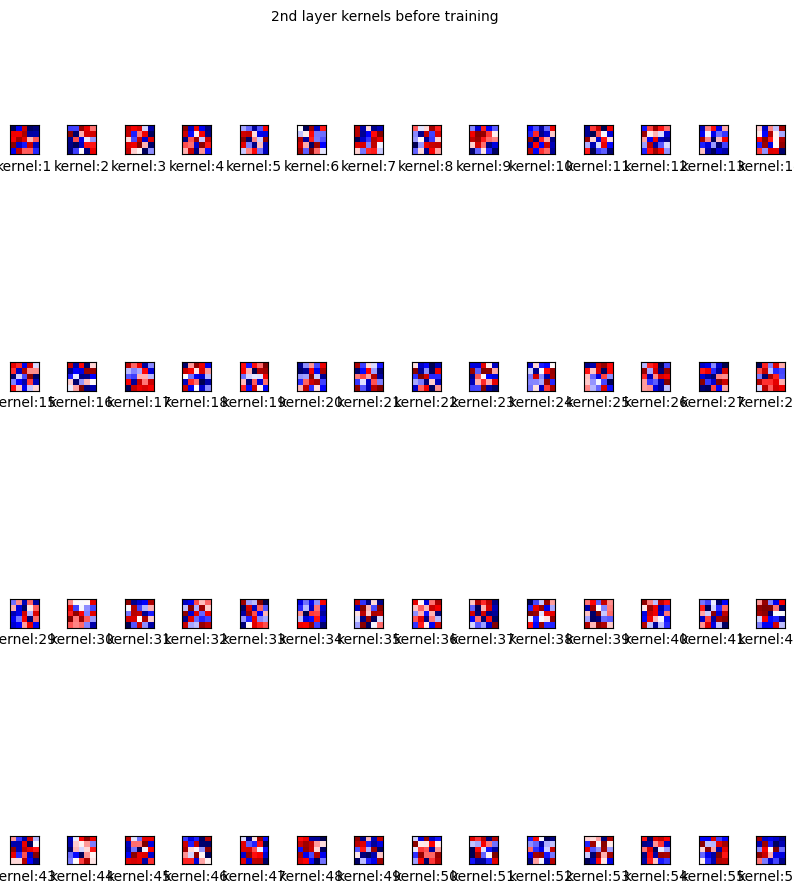

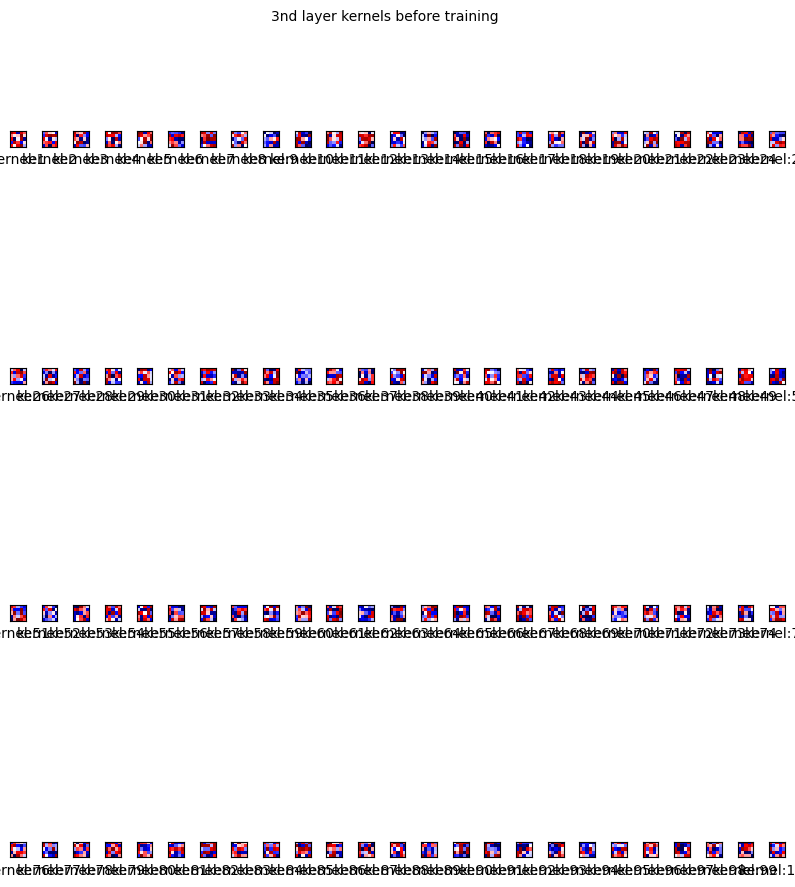

In [25]:
plot_parameters(model_CNN_BATCH_CPU.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model_CNN_BATCH_CPU.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )
plot_parameters(model_CNN_BATCH_CPU.state_dict()['cnn3.weight'], number_rows=4, name='3nd layer kernels before training' )

In [26]:
IMAGE_SIZE = 28

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [27]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [28]:
time_cpu_start = timer.time()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.Adam(model_CNN_BATCH_CPU.parameters(), lr = learning_rate)

accuracy_list_batch, loss_list_batch=train_model(model=model_CNN_BATCH_CPU,
                                                 n_epochs=10,
                                                 train_loader=train_loader,
                                                 validation_loader=validation_loader,
                                                 validation_dataset=validation_dataset,
                                                 optimizer=optimizer,
                                                 criterion=criterion,
                                                 use_cuda=False)
time_cpu_end = timer.time()
time_cpu_elapsed = time_cpu_end - time_cpu_start

Using CPU


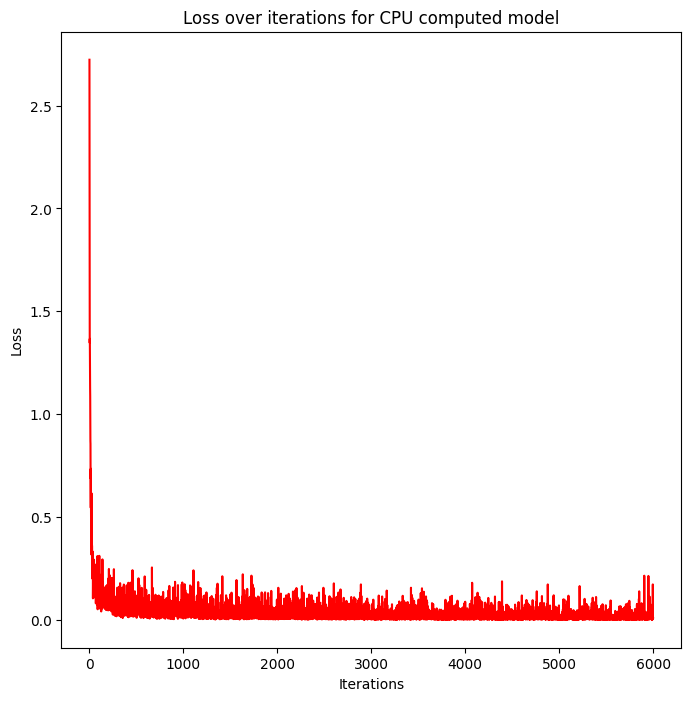

In [29]:
plt.figure(figsize=(8, 8))
plt.plot(loss_list_batch, color='red', label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations for CPU computed model')
plt.show()

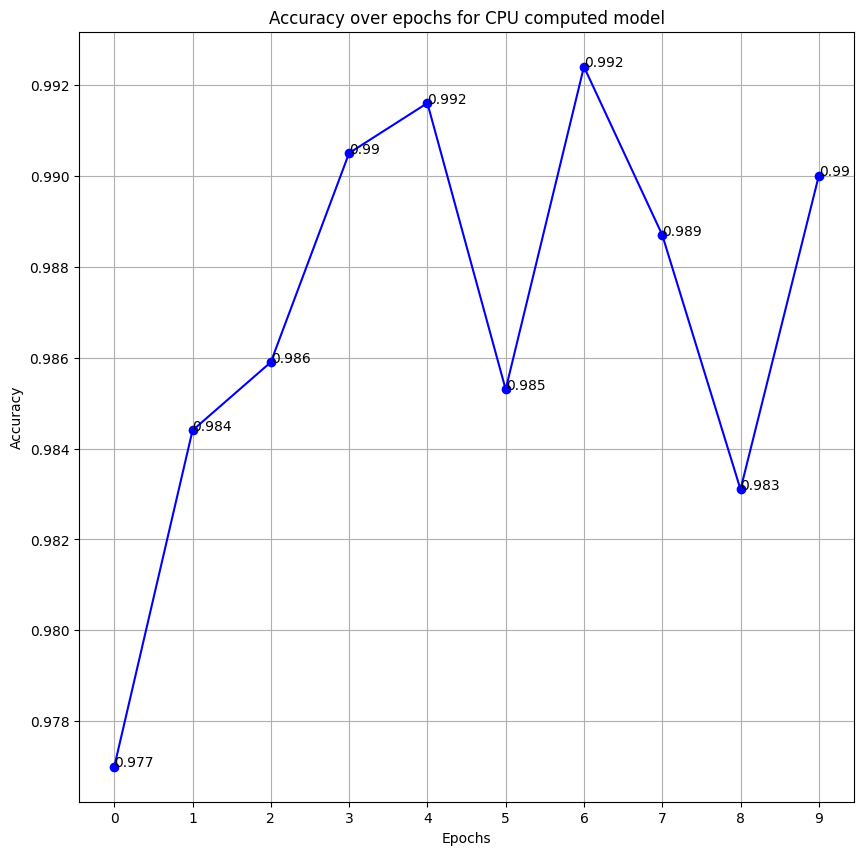

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(accuracy_list_batch,'bo-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs for CPU computed model')
plt.xticks(np.arange(0, len(accuracy_list_batch)))
plt.grid()
for i,j in enumerate(accuracy_list_batch):
    plt.text(i,j,np.round(j,3))
plt.show()

Convolution 1 wights


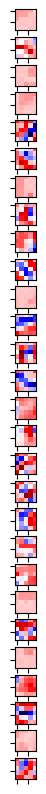

Convolution 2 wights


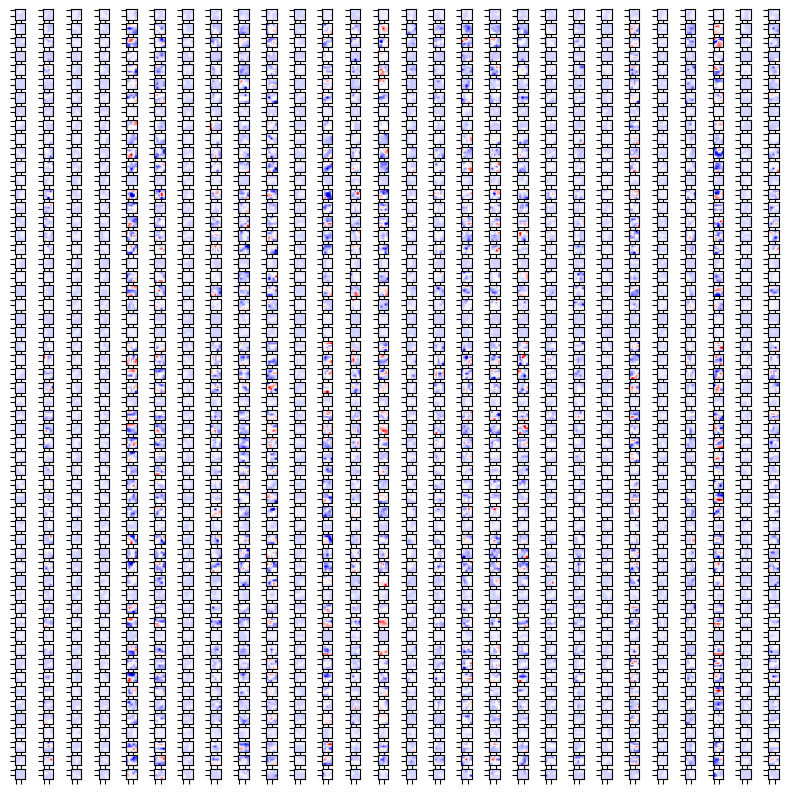

Convolution 3 wights


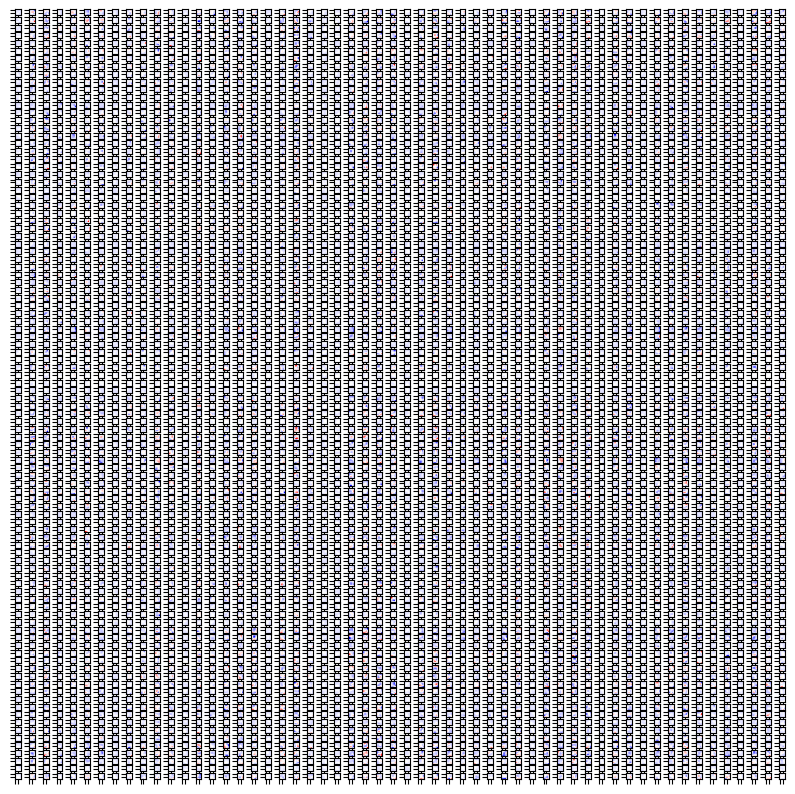

In [31]:
plot_channels(model_CNN_BATCH_CPU.state_dict()['cnn1.weight'],name='Convolution 1 wights')
plot_channels(model_CNN_BATCH_CPU.state_dict()['cnn2.weight'],name='Convolution 2 wights')
plot_channels(model_CNN_BATCH_CPU.state_dict()['cnn3.weight'],name='Convolution 3 wights')

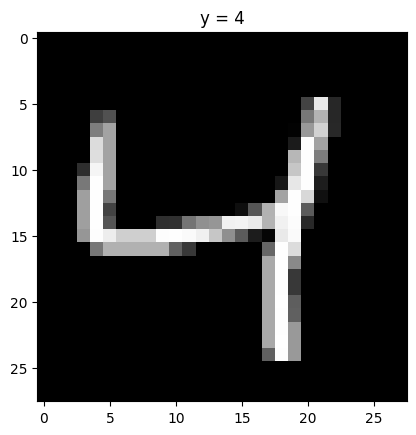

In [45]:
show_data(train_dataset[2])
out = model_CNN_BATCH_CPU.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))


28
Output after the 1st CNN


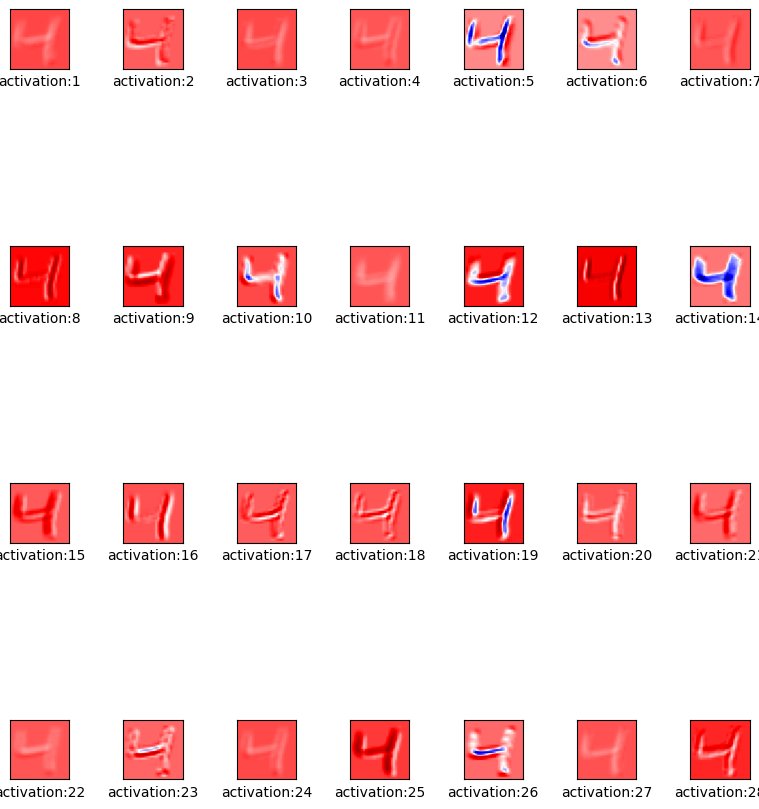

28
Output after the 1st Relu


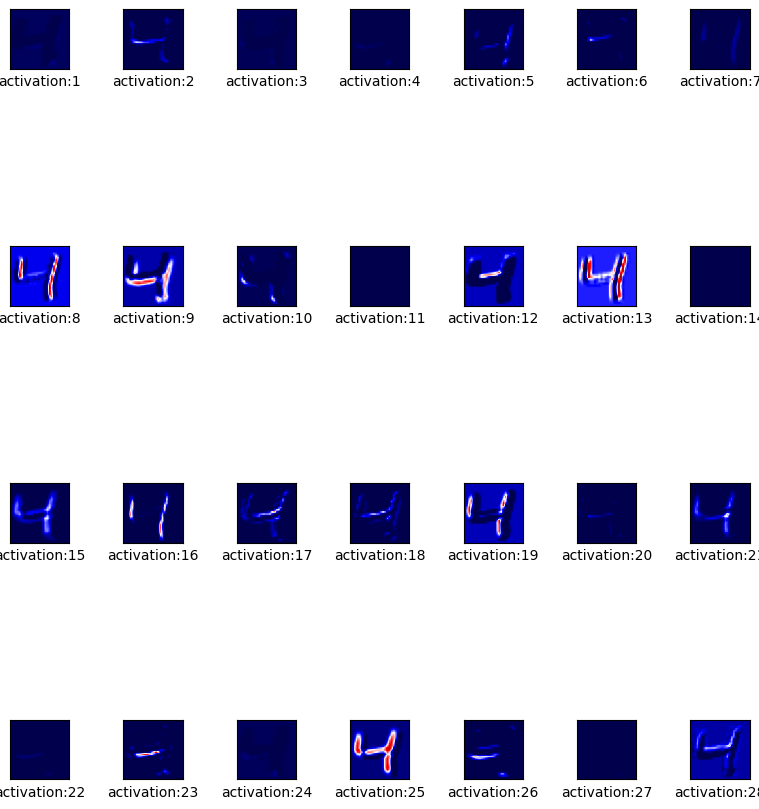

56
Output after the 2nd CNN


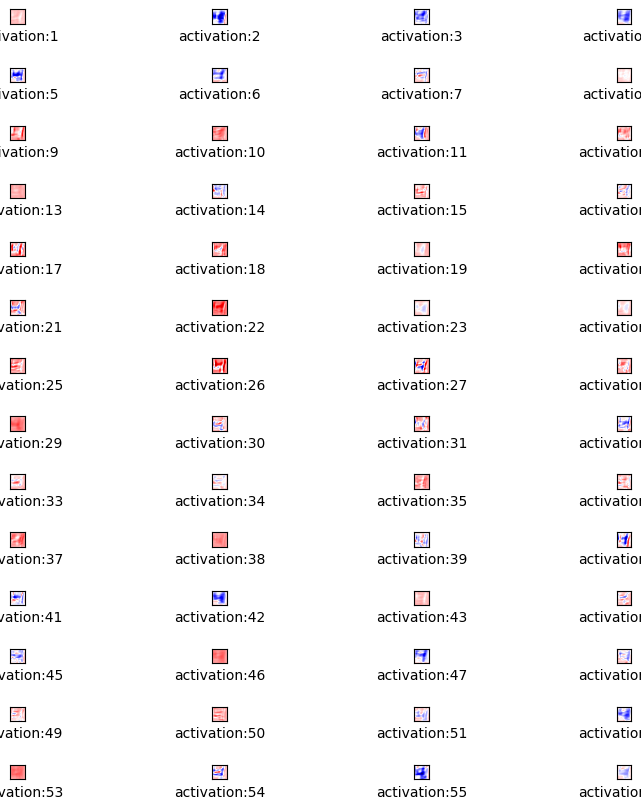

56
Output after the 2nd Relu


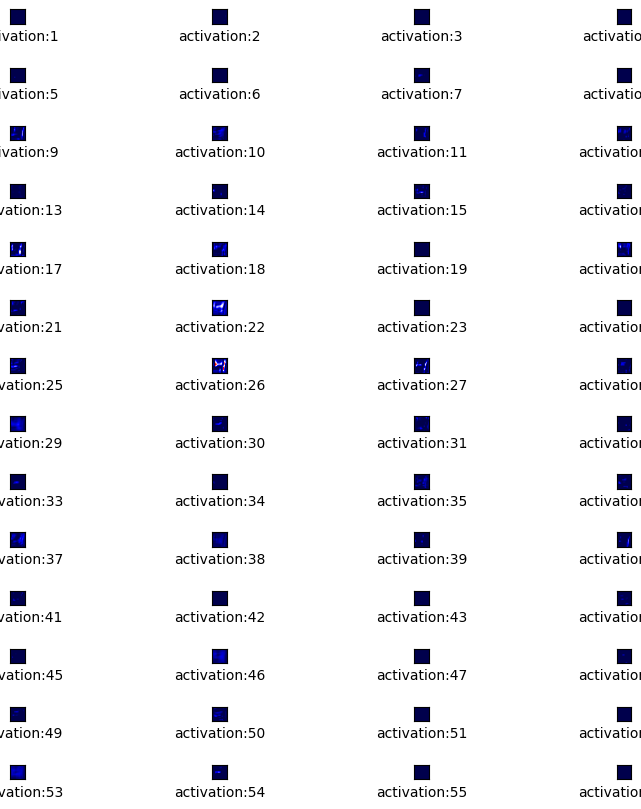

100
Output after the 3nd CNN


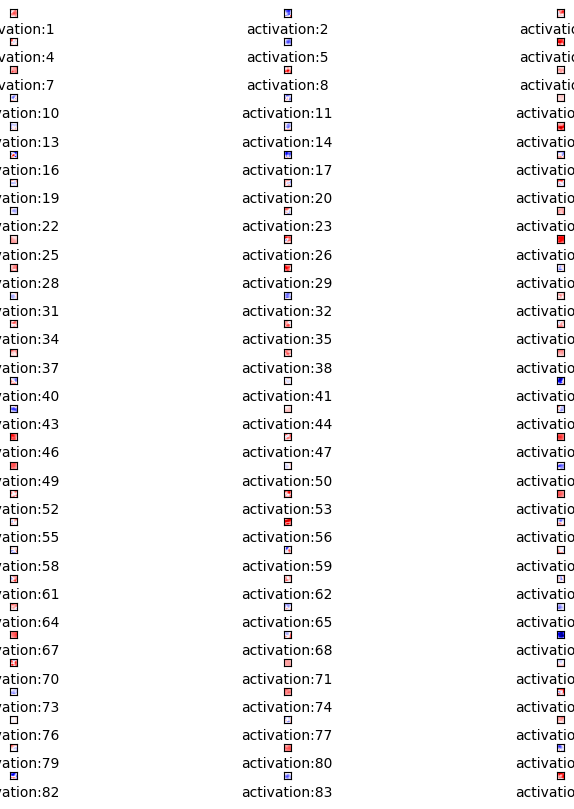

100
Output after the 3nd Relu


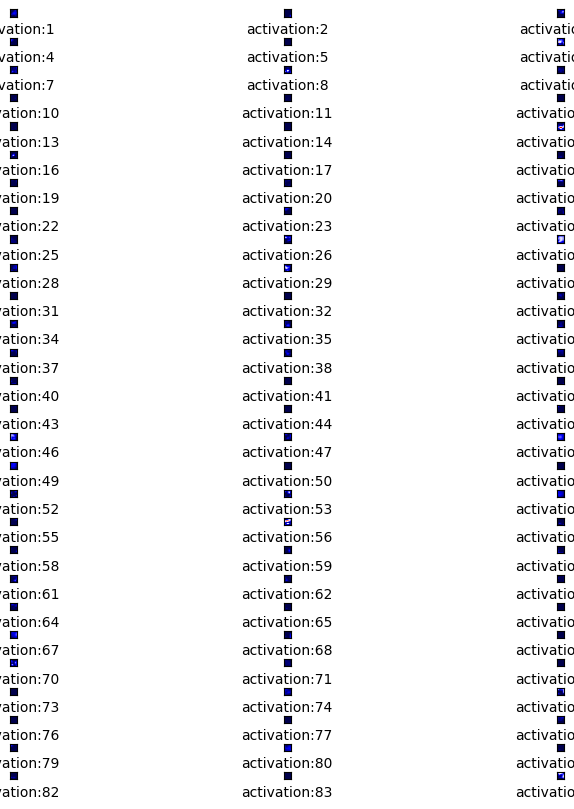

In [46]:
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")
plot_activations(out[2], number_rows=56//4, name="Output after the 2nd CNN")
plot_activations(out[3], number_rows=56//4, name="Output after the 2nd Relu")
plot_activations(out[4], number_rows=112//4, name="Output after the 3nd CNN")
plot_activations(out[5], number_rows=112//4, name="Output after the 3nd Relu")

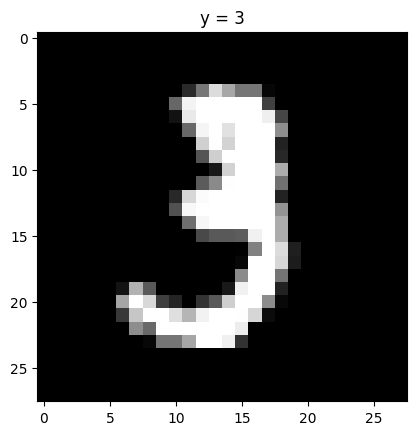

In [34]:
show_data(train_dataset[10])
out_1 = model_CNN_BATCH_CPU.activations(train_dataset[10][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))


28
Output after the 1st CNN


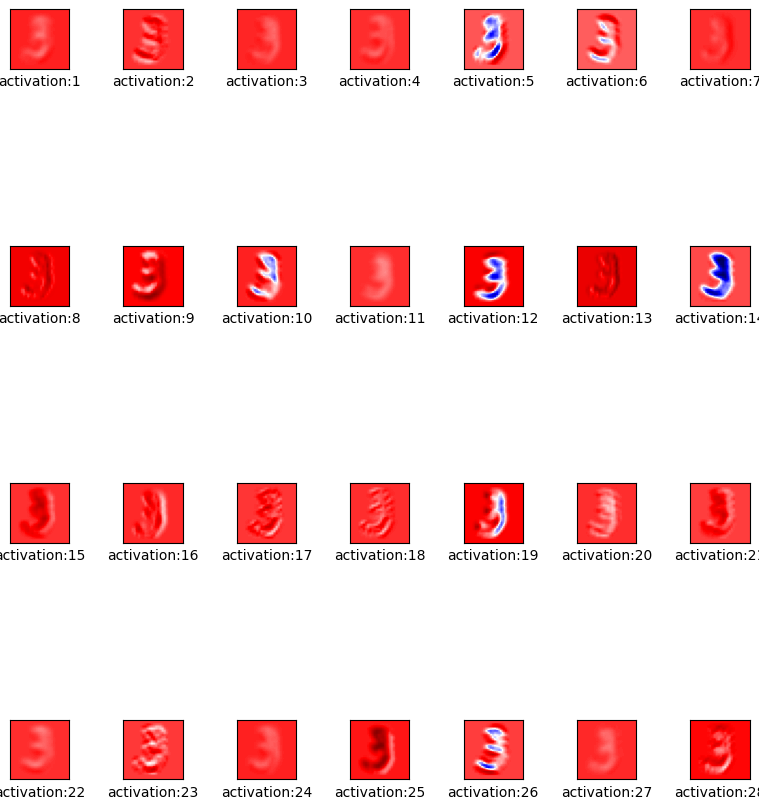

28
Output after the 1st Relu


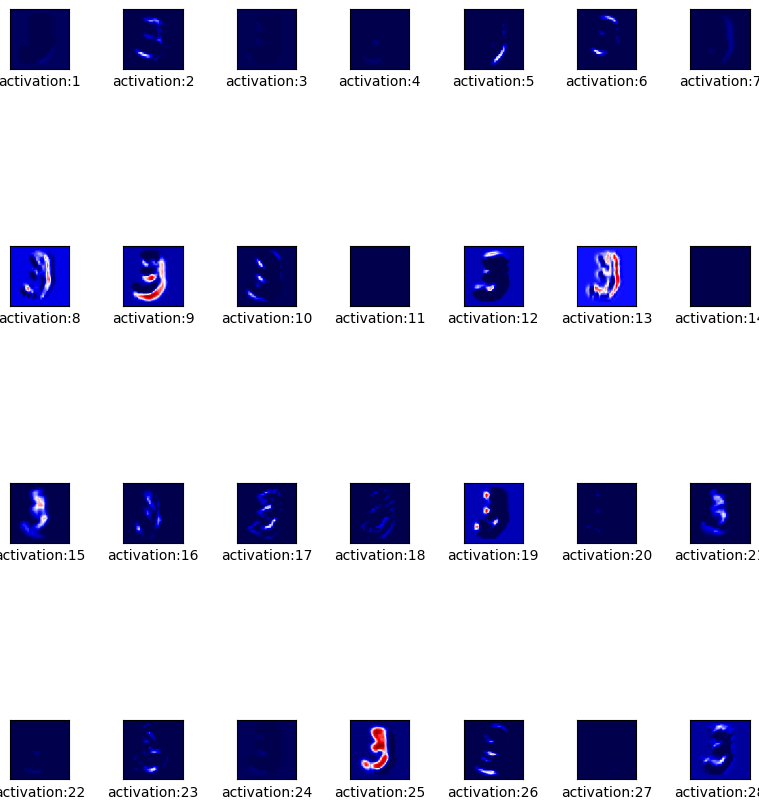

56
Output after the 2nd CNN


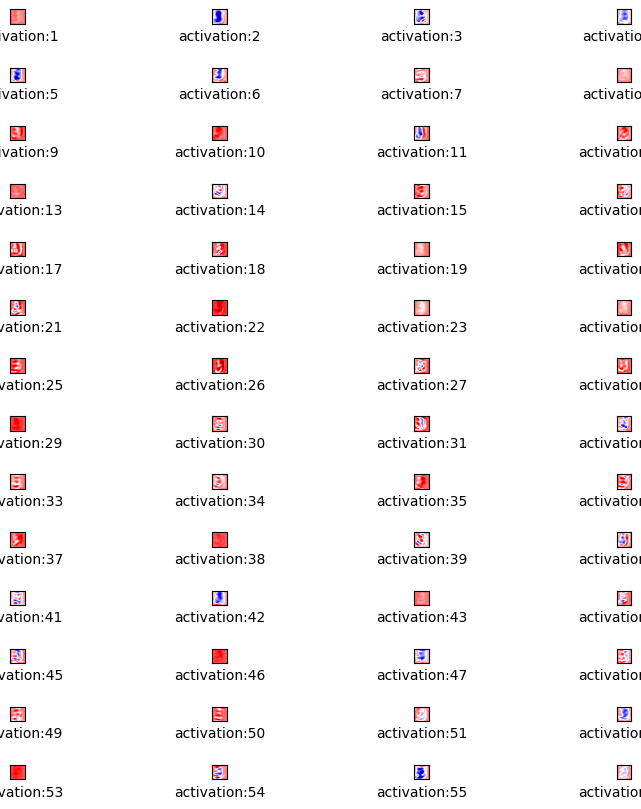

56
Output after the 2nd Relu


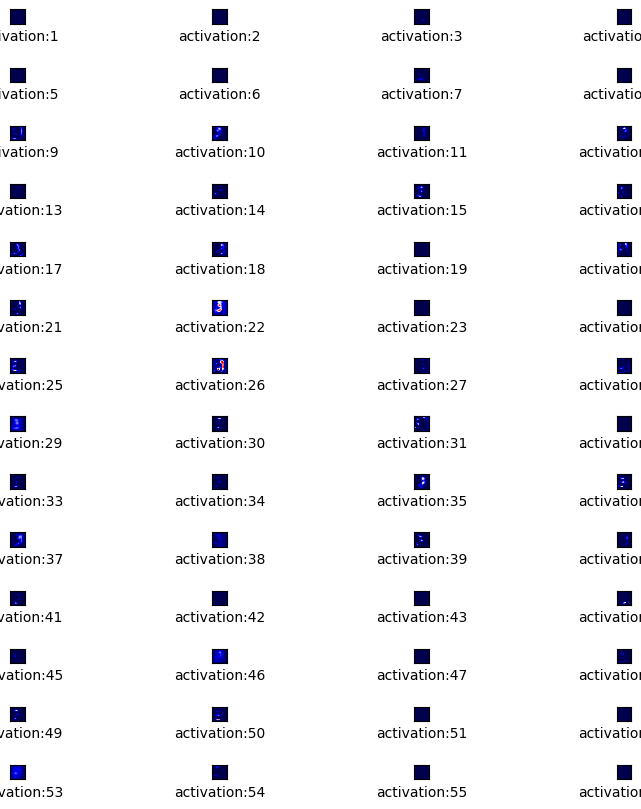

100
Output after the 3nd CNN


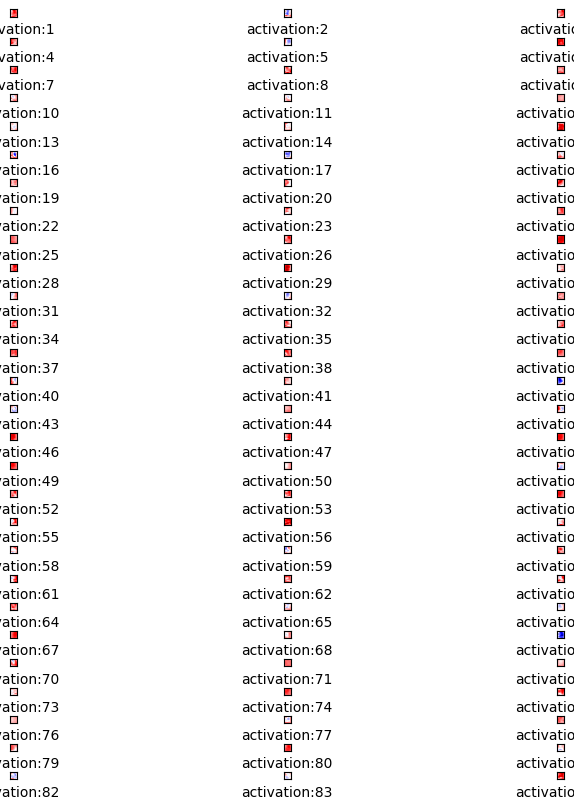

100
Output after the 3nd Relu


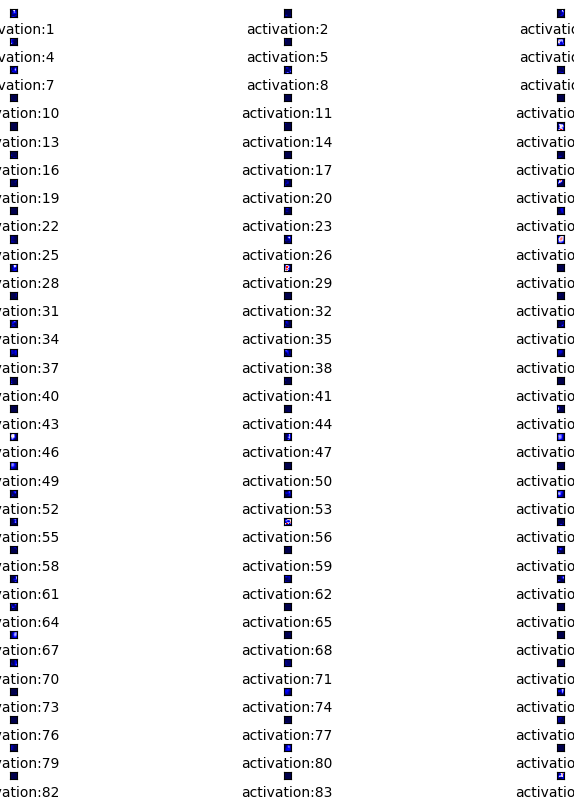

In [35]:
plot_activations(out_1[0], number_rows=4, name="Output after the 1st CNN")
plot_activations(out_1[1], number_rows=4, name="Output after the 1st Relu")
plot_activations(out_1[2], number_rows=56//4, name="Output after the 2nd CNN")
plot_activations(out_1[3], number_rows=56//4, name="Output after the 2nd Relu")
plot_activations(out_1[4], number_rows=112//4, name="Output after the 3nd CNN")
plot_activations(out_1[5], number_rows=112//4, name="Output after the 3nd Relu")

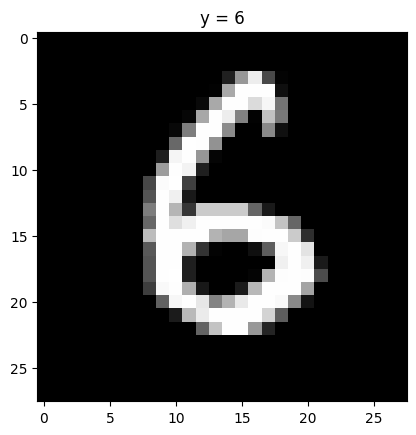

In [36]:
show_data(train_dataset[106])
out_2 = model_CNN_BATCH_CPU.activations(train_dataset[106][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

28
Output after the 1st CNN


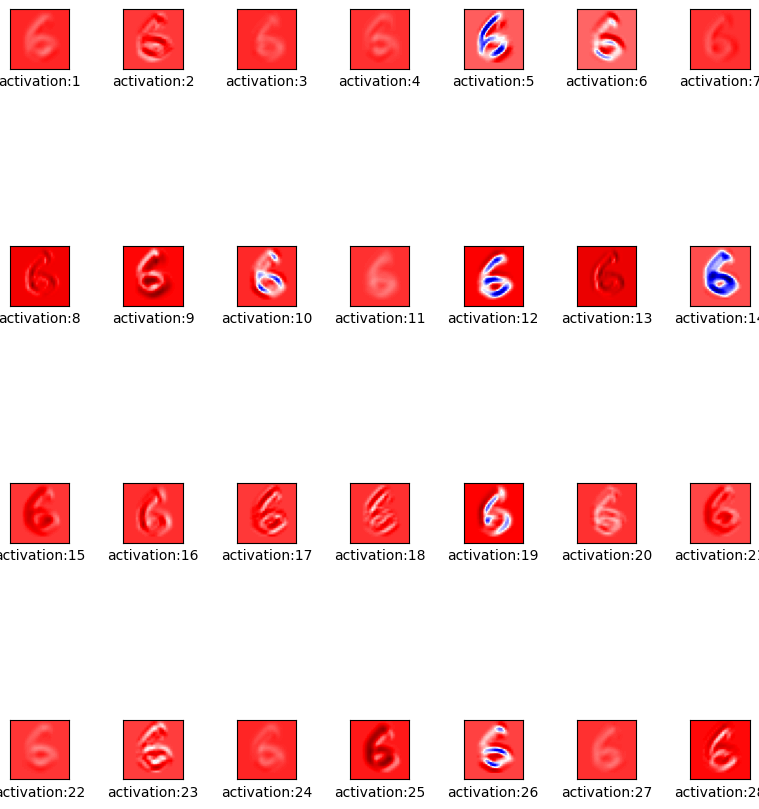

28
Output after the 1st Relu


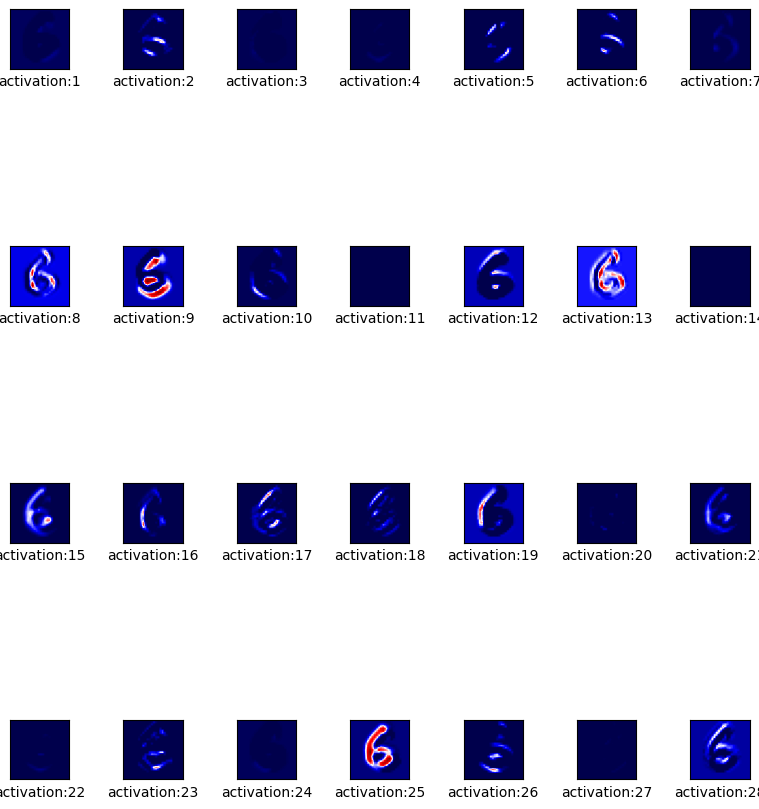

56
Output after the 2nd CNN


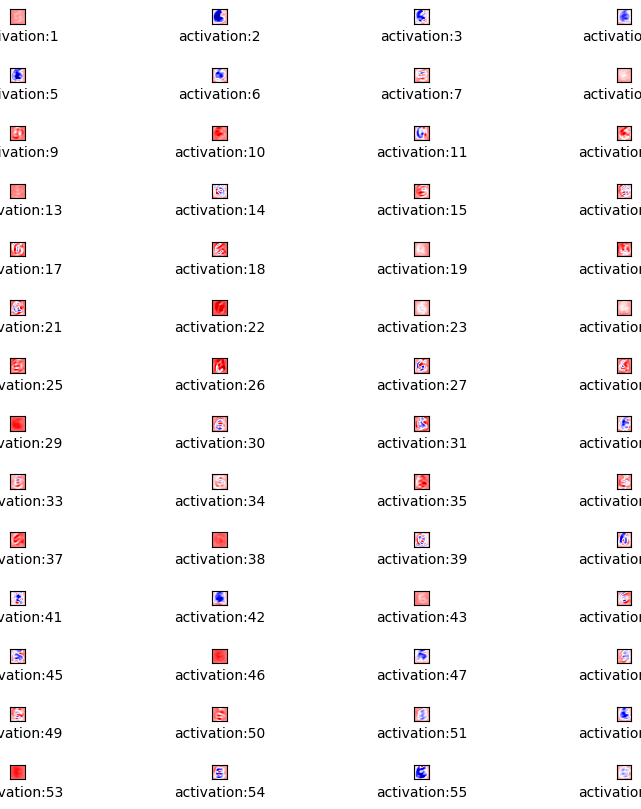

56
Output after the 2nd Relu


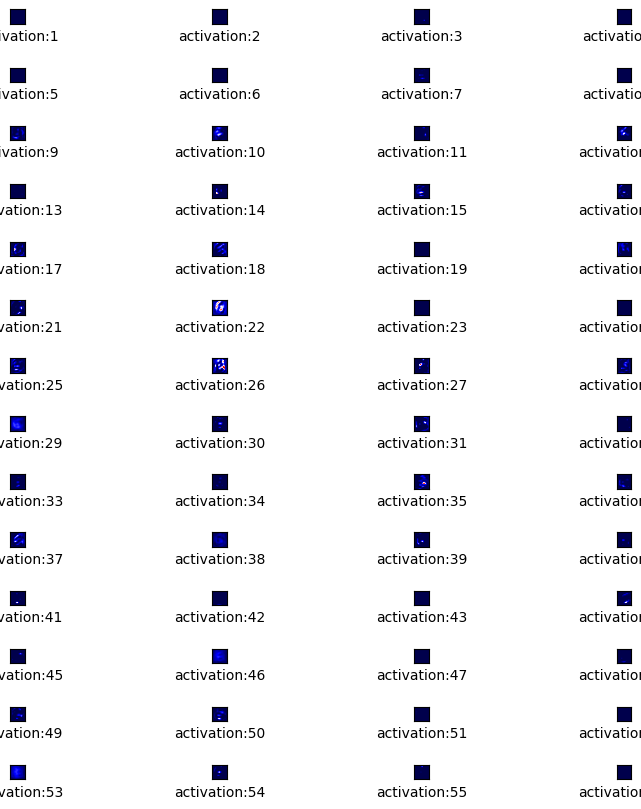

100
Output after the 3nd CNN


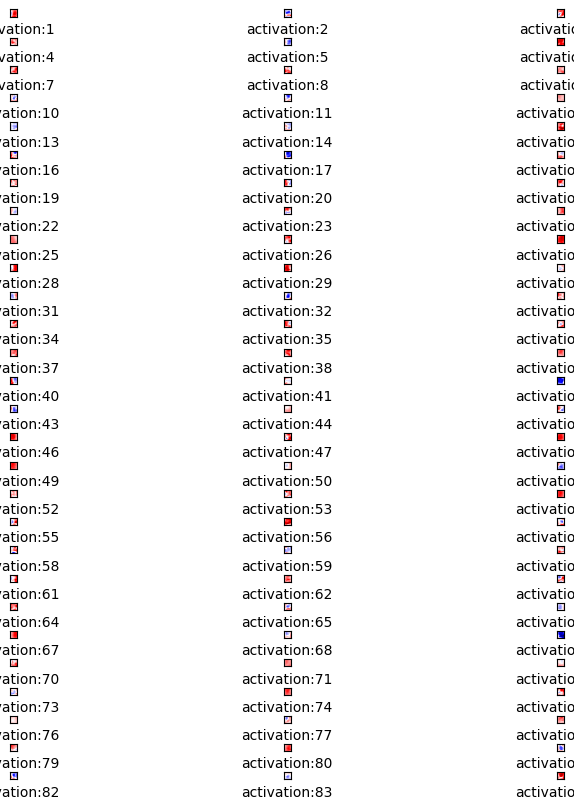

100
Output after the 3nd Relu


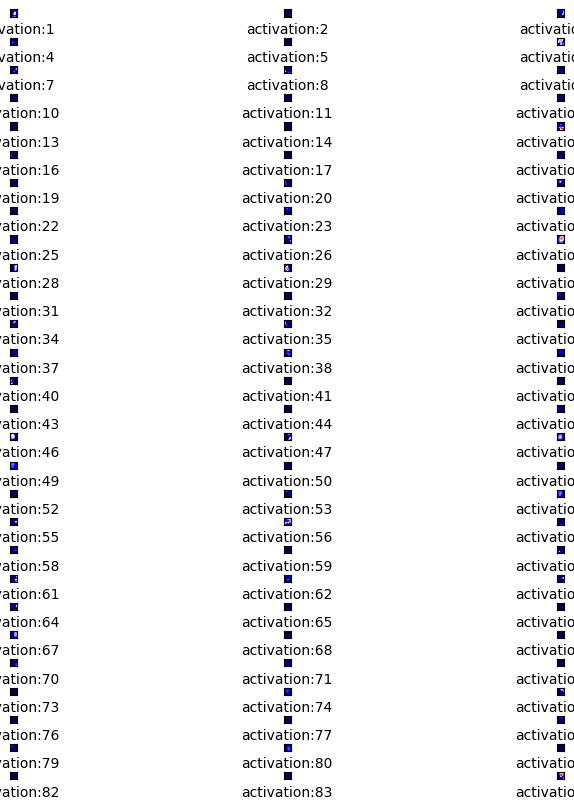

In [37]:
plot_activations(out_2[0], number_rows=4, name="Output after the 1st CNN")
plot_activations(out_2[1], number_rows=4, name="Output after the 1st Relu")
plot_activations(out_2[2], number_rows=56//4, name="Output after the 2nd CNN")
plot_activations(out_2[3], number_rows=56//4, name="Output after the 2nd Relu")
plot_activations(out_2[4], number_rows=112//4, name="Output after the 3nd CNN")
plot_activations(out_2[5], number_rows=112//4, name="Output after the 3nd Relu")

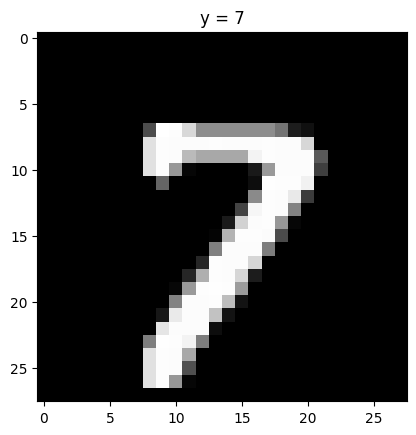

In [68]:
show_data(train_dataset[839])
out_3 = model_CNN_BATCH_CPU.activations(train_dataset[839][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

28
Output after the 1st CNN


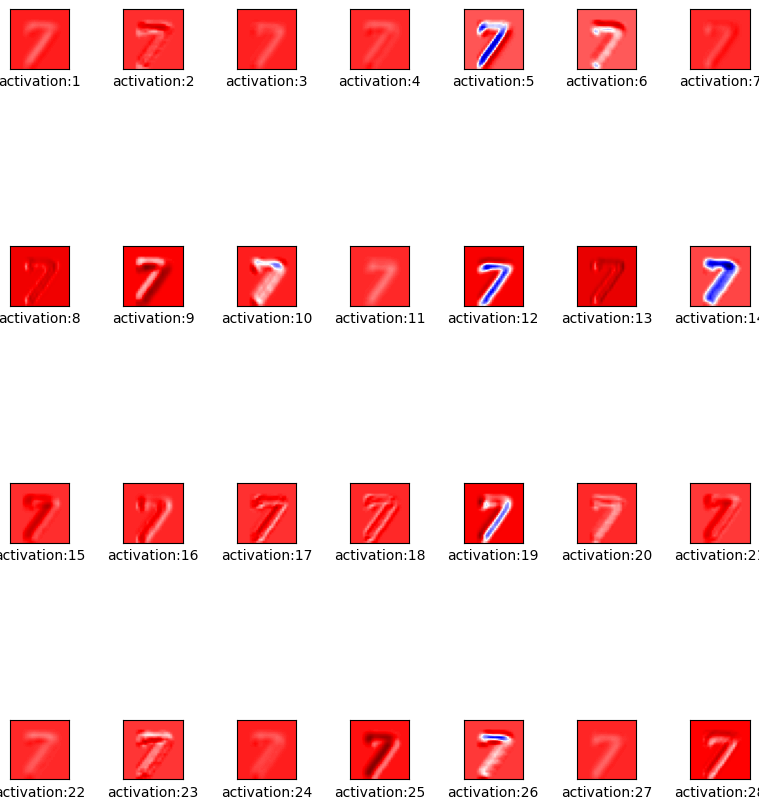

28
Output after the 1st Relu


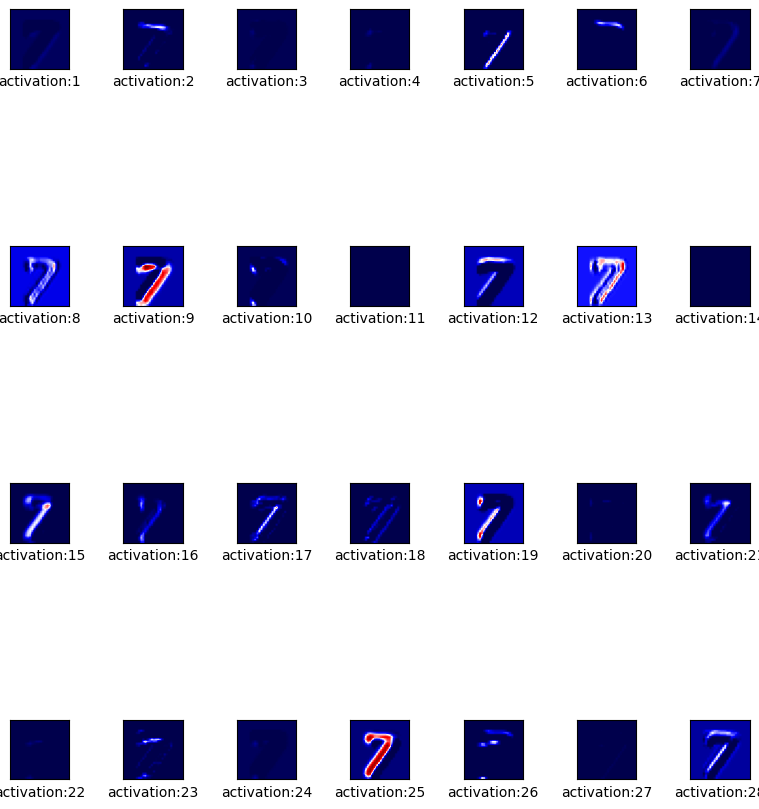

56
Output after the 2nd CNN


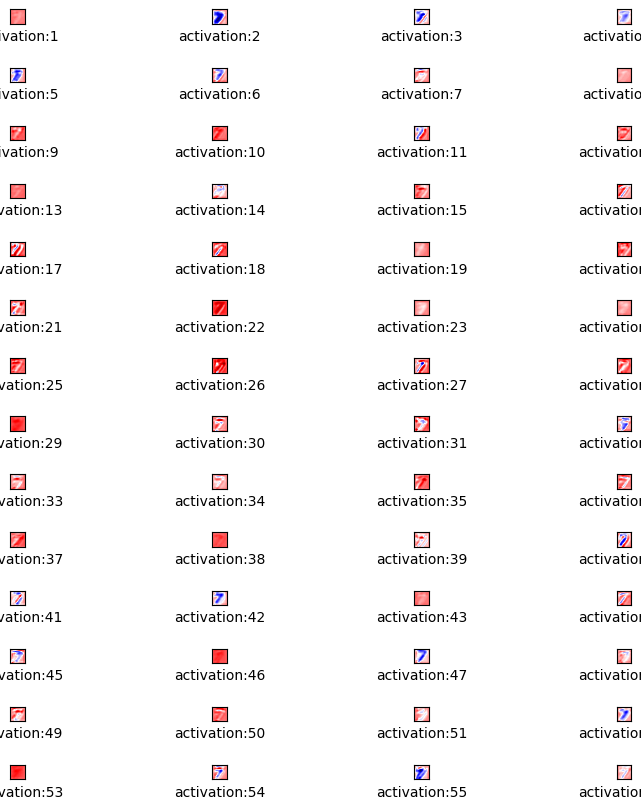

56
Output after the 2nd Relu


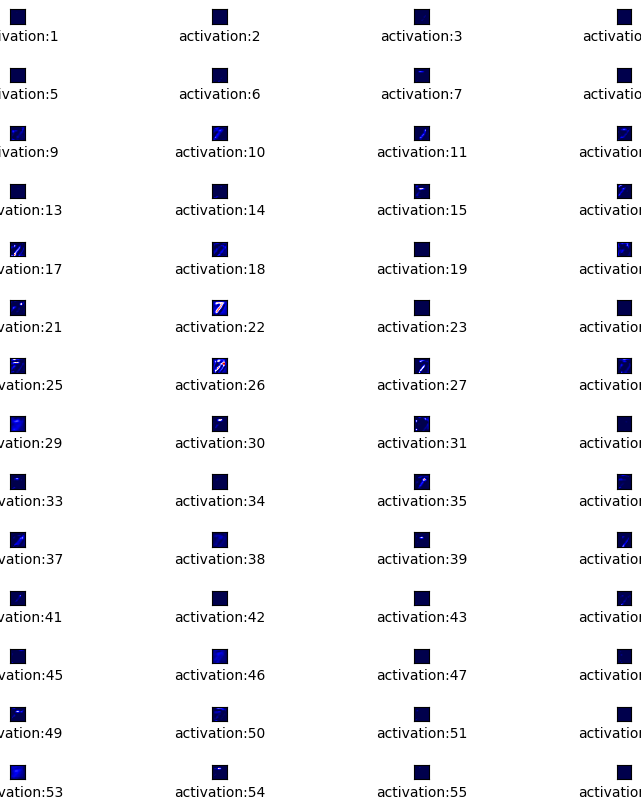

100
Output after the 3nd CNN


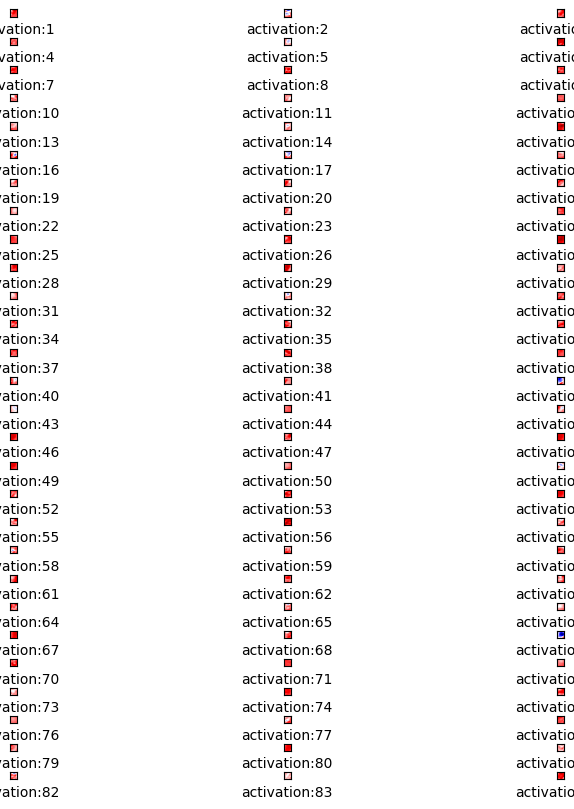

100
Output after the 3nd Relu


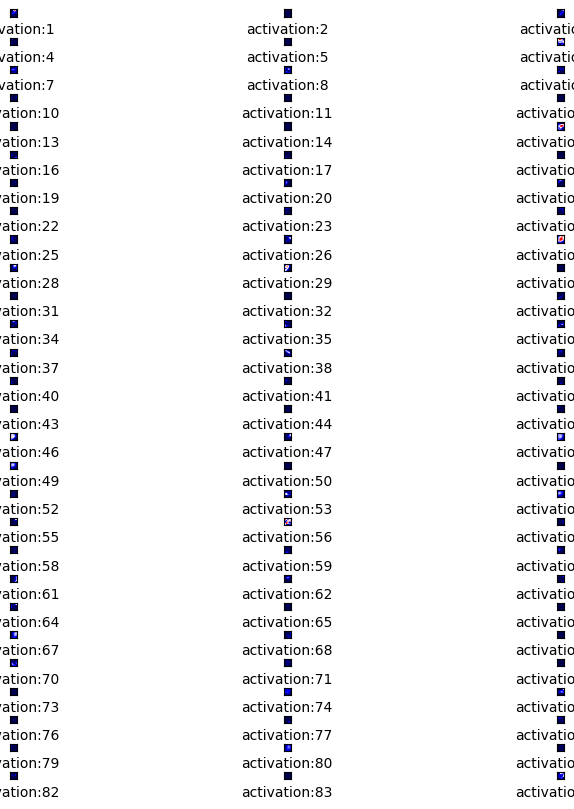

In [69]:
plot_activations(out_3[0], number_rows=4, name="Output after the 1st CNN")
plot_activations(out_3[1], number_rows=4, name="Output after the 1st Relu")
plot_activations(out_3[2], number_rows=56//4, name="Output after the 2nd CNN")
plot_activations(out_3[3], number_rows=56//4, name="Output after the 2nd Relu")
plot_activations(out_3[4], number_rows=112//4, name="Output after the 3nd CNN")
plot_activations(out_3[5], number_rows=112//4, name="Output after the 3nd Relu")

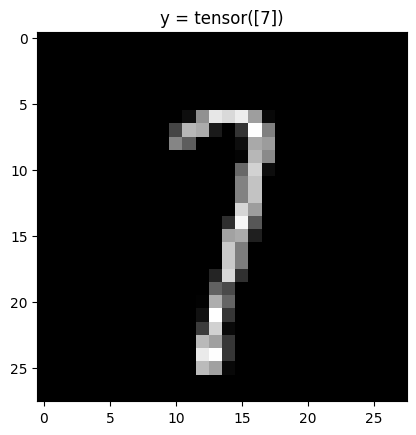

yhat:  tensor([1])


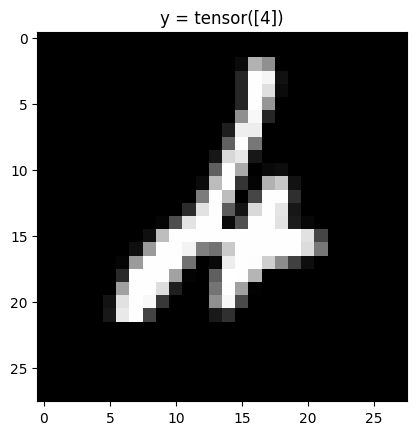

yhat:  tensor([6])


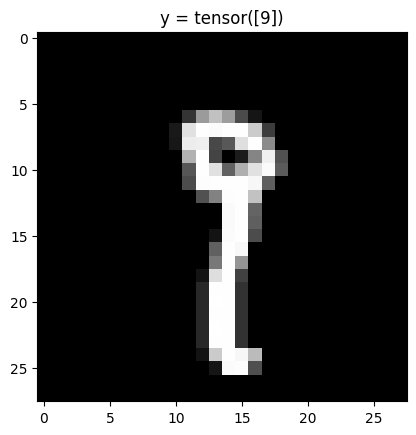

yhat:  tensor([8])


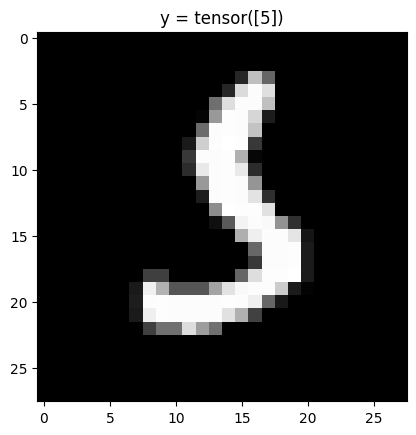

yhat:  tensor([3])


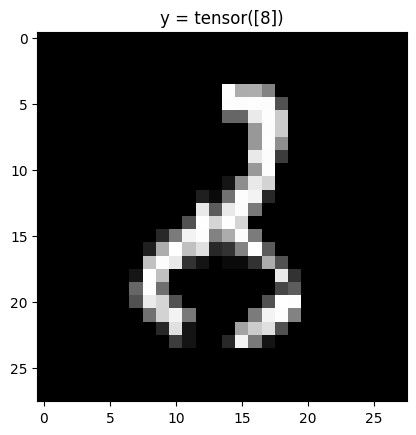

yhat:  tensor([2])


In [38]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model_CNN_BATCH_CPU(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  

In [70]:
time_gpu_start = timer.time()
optimizer = torch.optim.Adam(model_CNN_BATCH_GPU.parameters(), lr = 0.2)
accuracy_list_batch_second, loss_list_batch_second=train_model(model=model_CNN_BATCH_GPU,
                                                               n_epochs=10,
                                                               train_loader=train_loader,
                                                               validation_loader=validation_loader,
                                                               validation_dataset=validation_dataset,
                                                               optimizer=optimizer,
                                                               criterion=criterion,
                                                               use_cuda=True)
time_gpu_end = timer.time()
time_gpu_elapsed = time_gpu_end - time_gpu_start

Using GPU


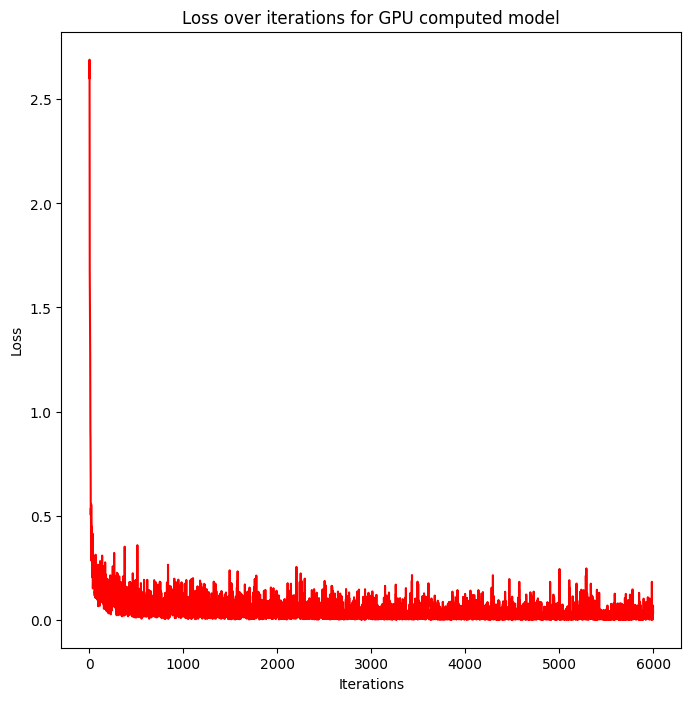

In [71]:
plt.figure(figsize=(8, 8))
plt.plot(loss_list_batch_second, color='red', label='Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations for GPU computed model')
plt.show()

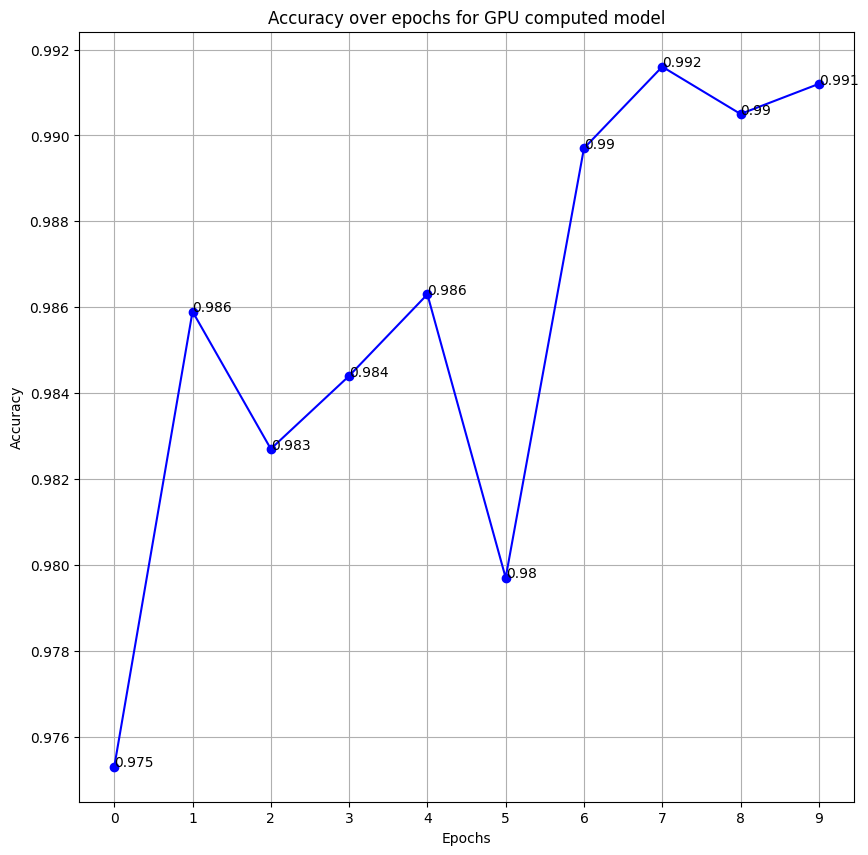

In [72]:
plt.figure(figsize=(10, 10))
plt.plot(accuracy_list_batch_second,'bo-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs for GPU computed model')
plt.xticks(np.arange(0, len(accuracy_list_batch_second)))
plt.grid()
for i,j in enumerate(accuracy_list_batch_second):
    plt.text(i,j,np.round(j,3))
plt.show()

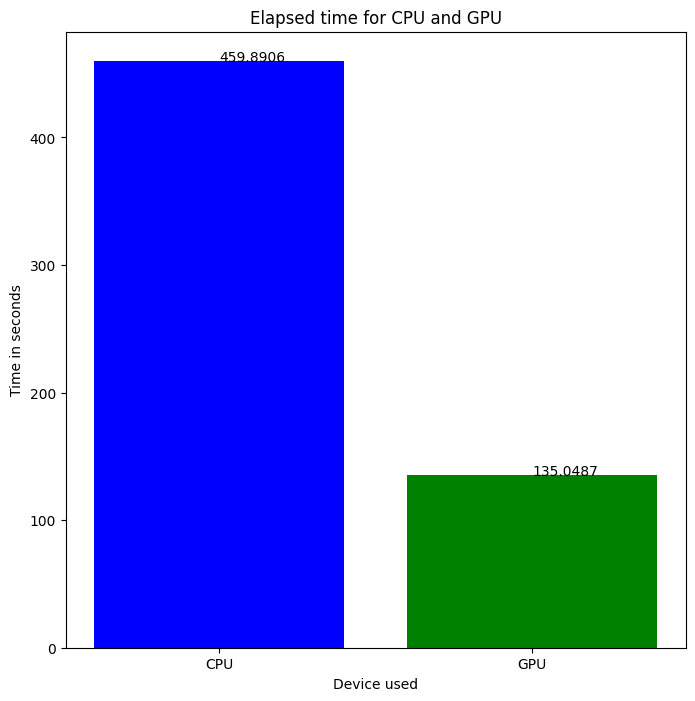

In [73]:
times = [time_cpu_elapsed, time_gpu_elapsed]
labels = ['CPU', 'GPU']
colors = ['blue', 'green']

plt.figure(figsize=(8, 8))
plt.bar(labels, times, color=colors)
plt.title('Elapsed time for CPU and GPU')
plt.xlabel('Device used')
plt.ylabel('Time in seconds')
for i,j in enumerate(times):
    plt.text(i,j,np.round(j,4))
plt.show()

In [74]:
print(f"Time difference between CPU and GPU: {np.round(time_cpu_elapsed-time_gpu_elapsed, 3)} seconds approximately. (calculation used: cpu_time - gpu_time)")
print(f"Accuracy difference between CPU and GPU: {np.round(np.mean(accuracy_list_batch) - np.mean(accuracy_list_batch_second), 3)*100}% approximately. (calculation used: cpu_accuracy_mean - gpu_accuracy_mean)")
print(f"Loss difference between CPU and GPU: {np.round(np.mean(loss_list_batch_second) - np.mean(loss_list_batch), 3)} approximately. (calculation used: gpu_loss_mean - cpu_loss_mean)")

Time difference between CPU and GPU: 324.842 seconds approximately. (calculation used: cpu_time - gpu_time)
Accuracy difference between CPU and GPU: 0.1% approximately. (calculation used: cpu_accuracy_mean - gpu_accuracy_mean)
Loss difference between CPU and GPU: 0.009 approximately. (calculation used: gpu_loss_mean - cpu_loss_mean)


In [75]:
torch.save(model_CNN_BATCH_CPU.state_dict(), 'CNN_model_CPU.pt')
torch.save(model_CNN_BATCH_GPU.state_dict(), 'CNN_model_GPU.pt')